In [1]:
import torch
print("DEVICE NAME:", torch.cuda.get_device_name(0))
print("DEVICE COUNT:", torch.cuda.device_count())
print("CURRENT DEVICE:", torch.cuda.current_device())

DEVICE NAME: GeForce GTX 1080
DEVICE COUNT: 1
CURRENT DEVICE: 0


In [3]:
from fastai import *
from fastai.text import *
from fastai.core import *
from pathlib import Path
import pandas as pd
import numpy as np
%cd ..
from ulmfit.pretrain_lm import *
from fastai.callbacks import CSVLogger, SaveModelCallback


/home/mkreso/master_thesis/ulmfit-multilingual


In [4]:
wiki_data_path = Path('data/wiki/hr-100/')

In [15]:
wiki_data_path.ls()

[PosixPath('data/wiki/hr-100/hr.wiki.train.tokens'),
 PosixPath('data/wiki/hr-100/hr.wiki.test.tokens'),
 PosixPath('data/wiki/hr-100/models'),
 PosixPath('data/wiki/hr-100/hr.wiki.valid.tokens'),
 PosixPath('data/wiki/hr-100/SviTvitovi.txt'),
 PosixPath('data/wiki/hr-100/data_lm'),
 PosixPath('data/wiki/hr-100/SviTvitovi.csv')]

In [6]:
data_lm1 = load_data(wiki_data_path, 'data_lm', bs=30)

In [8]:
itos = data_lm1.vocab.itos


In [10]:
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', itos[:20])

Size of vocabulary: 60003
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '.', ',', 'je', ':', 'i', 'u', "'", '&', '\n \n ', '\n ', 'se', 'na']


In [11]:
with open(wiki_data_path/'models/itos.pkl',"wb") as f:
    pickle.dump(data_lm1.vocab.itos, f)

In [13]:
model_path = Path('data/wiki/hr-100/models')

In [14]:
model_path.ls()

[PosixPath('data/wiki/hr-100/models/lm_5.pth'),
 PosixPath('data/wiki/hr-100/models/lm_6.pth'),
 PosixPath('data/wiki/hr-100/models/hr-100-best.pth'),
 PosixPath('data/wiki/hr-100/models/lm_10.pth'),
 PosixPath('data/wiki/hr-100/models/lm_14.pth'),
 PosixPath('data/wiki/hr-100/models/lm_3.pth'),
 PosixPath('data/wiki/hr-100/models/lm-history.csv'),
 PosixPath('data/wiki/hr-100/models/lm_1.pth'),
 PosixPath('data/wiki/hr-100/models/itos.pkl'),
 PosixPath('data/wiki/hr-100/models/lm_9.pth'),
 PosixPath('data/wiki/hr-100/models/tmp.pth'),
 PosixPath('data/wiki/hr-100/models/lm_7.pth'),
 PosixPath('data/wiki/hr-100/models/lm_8.pth'),
 PosixPath('data/wiki/hr-100/models/lm_15.pth'),
 PosixPath('data/wiki/hr-100/models/lm_12.pth'),
 PosixPath('data/wiki/hr-100/models/lm_13.pth'),
 PosixPath('data/wiki/hr-100/models/lm_11.pth'),
 PosixPath('data/wiki/hr-100/models/lm_2.pth'),
 PosixPath('data/wiki/hr-100/models/lm_4.pth')]

In [23]:
data_lm = TextLMDataBunch.from_csv(wiki_data_path, 'SviTvitovi.csv', text_cols=1, bs=30)

In [25]:
itos, stoi, data_path = data_lm.vocab.itos, data_lm.vocab.stoi, data_lm.path
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', itos[:20])
print(str(data_path))

Size of vocabulary: 9750
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '/', '\n ', ',', '.', ':', 'i', 'u', 't.co', 'http', 'je', 'na', 'se']
data/wiki/hr-100


In [26]:
data_lm.show_batch()

idx,text
0,"/ xxunk \n xxbos xxunk xxunk fm nas je xxunk u goste sutra > xxmaj radio xxmaj student 100.5 xxunk ili http : / / t.co / xxunk od 20:00 ... http : / / t.co / xxunk \n xxbos xxmaj neki ljudi govore , xxmaj dinamo je nekada bio ponos , xxmaj dinamo su voljeli i borili su se za njega ... xxmaj ne znam za druge"
1,"xxmaj lučić , xxmaj cipetić , xxmaj hajder , xxmaj kušeta , xxmaj xxunk , xxmaj mujan , xxmaj jelić @hajduk_hr \n xxbos @sasastankovic xxmaj da ... ma , godišnji će za tjedan dana .. ne se xxunk : ) \n xxbos xxmaj možete se xxunk oko cure / momka , faksa / posla , al jedini trud koji se zaista xxunk 100 % isplati je vježbanje i"
2,"xxup xxunk - a xxmaj hercegovine ! xxmaj večerašnji protivnik bio je xxunk xxmaj xxunk xxrep 4 . http : / / t.co / xxunk \n xxbos xxmaj ne mogu ove ljude kojima je xxunk šta će xxunk na cesti mislit nego vlastita sreća i xxunk . \n xxbos xxmaj xxunk je xxunk xxunk i radna mjesta , a sada poput xxmaj xxunk "" pere "" ruke od"
3,"/ / t.co / xxunk \n xxbos xxmaj biće mi žao možda kad se sutra xxunk i xxunk sve što sam xxunk \n xxbos xxmaj xxunk te jer xxup ti si sve sto mogu da xxunk . \n xxbos xxmaj inace , xxmaj tesla je bio veliki xxunk , otkud je xxunk znanje za svoje xxunk . xxmaj upoznao se s velikim xxmaj xxunk i xxunk xxmaj"
4,"tog godišnjeg u xxunk količinama \n xxbos @stellar_musique @pearsawfly @kresoz to objašnjava xxunk xxunk računa vikendom kad od 5 jedan prođe , a ostali čekaju pon . \n xxbos osim što je to svima jasno , hdz i javno xxunk svoje xxunk . xxunk sve niže , vraćamo se sve dalje u prošlost . # izborihr \n xxbos xxunk @vladarh pa da vidimo kako ćete ih promijenit"


In [27]:
len(data_lm.train_ds), len(data_lm.valid_ds)


(7999, 2001)

In [28]:
pretrained_fnames = ['hr-100-best', 'itos']


In [35]:
learner = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=pretrained_fnames, drop_mult=0.9, 
                                 model_dir='./models')

/home/mkreso/master_thesis/fastai/fastai/datasets.py:153: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


In [36]:
learner.callback_fns += [partial(CSVLogger, filename=f"{learner.model_dir}/lm-history"),
                         partial(SaveModelCallback, every='epoch', name='lm_finetuned')]

In [37]:
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))


In [38]:
learner.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


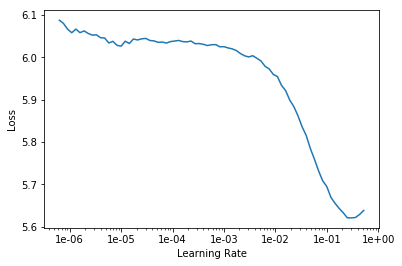

In [39]:
learner.recorder.plot(skip_end=15)


In [40]:
moms = (0.8, 0.7)


In [41]:
learner.fit_one_cycle(1, 1e-2, moms=moms)


epoch,train_loss,valid_loss,accuracy
1,4.771255,3.926194,0.378799


In [42]:
learner.unfreeze()

In [48]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


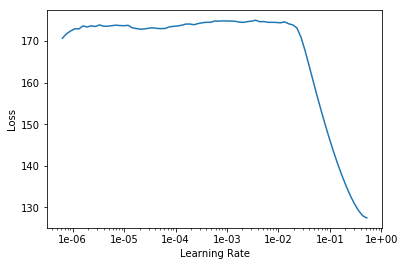

In [49]:
learner.recorder.plot(skip_end=15)

In [50]:
learner.fit_one_cycle(20, 1e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,138.098755,22.936020,0.008613
2,30.210627,8.949481,0.111346
3,11.893117,6.305987,0.153561
4,7.615515,5.253425,0.195983
5,6.302263,4.935703,0.261760
6,5.921392,4.834846,0.294265
7,5.601254,4.673698,0.315300
8,5.408549,4.583824,0.332443
9,5.323301,4.578050,0.335631
10,5.223105,4.492643,0.339689
